# Predicting Heart Disease with EDA Plotting enhanced Version

### Feature Distribution Comparison ###


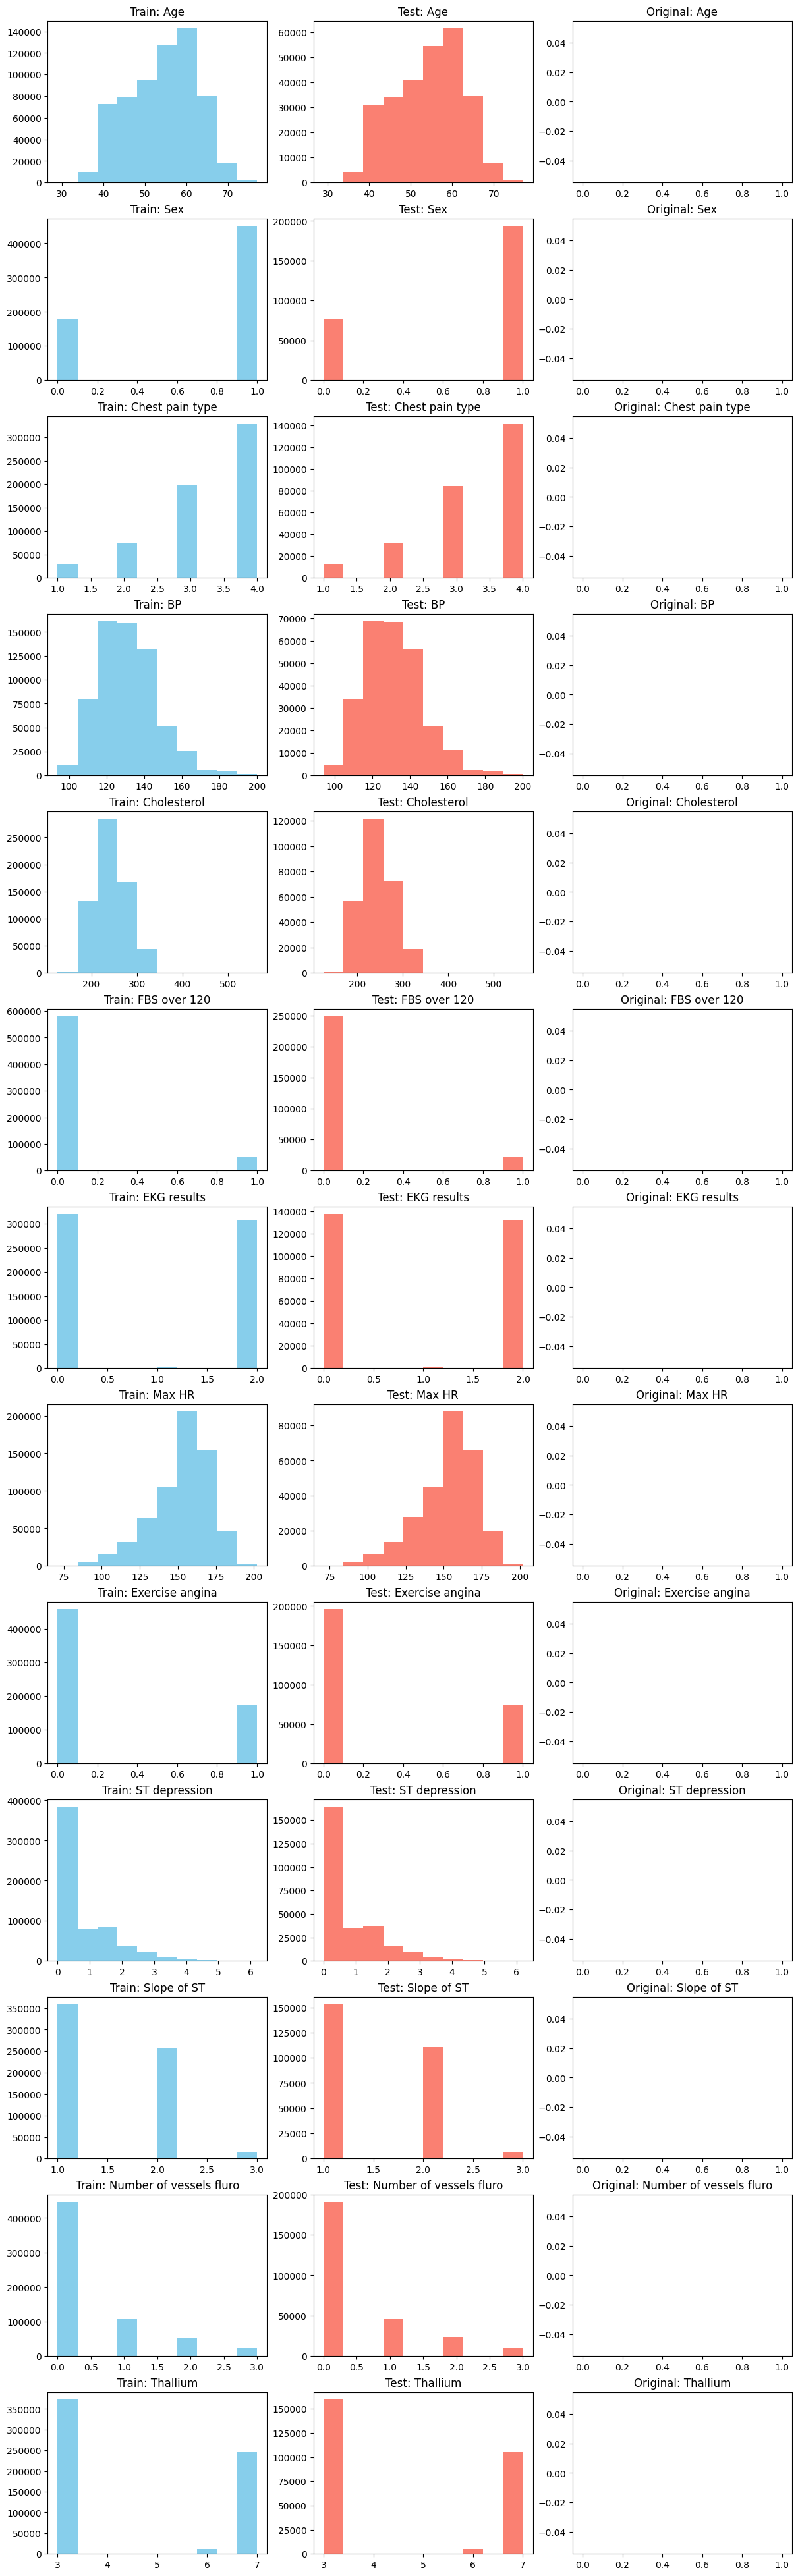

--- Starting Ensemble Generation ---
✅ Blended: submission.csv | Weight: 2.8
✅ Blended: 0.95399.csv | Weight: 0.2

SUCCESS: Ensemble saved to 'submission.csv'
### Final Submission Preview ###
        id  Heart Disease
0   630000       0.948194
1   630001       0.010890
2   630002       0.990013
3   630003       0.006479
4   630004       0.221822
5   630005       0.981302
6   630006       0.007634
7   630007       0.560245
8   630008       0.991021
9   630009       0.015024
10  630010       0.902361
11  630011       0.380112
12  630012       0.977600
13  630013       0.970349
14  630014       0.994711
15  630015       0.143477
16  630016       0.005562
17  630017       0.976806
18  630018       0.021559
19  630019       0.405364


In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from bokeh.plotting import figure, gridplot


BLEND_CONFIG = {
    "/kaggle/input/datasets/kami1976/s6e2d8/submission.csv": 2.80,
    "/kaggle/input/datasets/yusufmurtaza01/s6e2d7/0.95399.csv": 0.20,
}

OUTPUT_FILE = "submission.csv"
ID_COL = "id"
TARGET_COL = "Heart Disease"

def generate_ensemble(config, output_path):
    """
    Performs a weighted linear ensemble of submission files.
    Logic: (Pred_A * Weight_A + Pred_B * Weight_B) / Total_Weight
    """
    combined_predictions = None
    total_weight = 0.0
    
    print(f"--- Starting Ensemble Generation ---")

    for filepath, weight in config.items():
        if not os.path.exists(filepath):
            print(f"⚠️ Error: File not found: {filepath}")
            continue
            
        # 1. Load the submission file
        df = pd.read_csv(filepath)
        
        # 2. Add weighted predictions to our running total
        # We perform element-wise addition. This assumes 'id' columns are identical,
        # which is standard for Kaggle competition files.
        if combined_predictions is None:
            # Initialize the container with the first file's data
            combined_predictions = df.copy()
            combined_predictions[TARGET_COL] = df[TARGET_COL] * weight
        else:
            # Add subsequent files
            combined_predictions[TARGET_COL] += df[TARGET_COL] * weight
            
        total_weight += weight
        print(f"✅ Blended: {filepath.split('/')[-1]} | Weight: {weight}")

    # 3. Normalize by dividing by the sum of weights
    if total_weight > 0:
        combined_predictions[TARGET_COL] /= total_weight
    else:
        raise ValueError("Total weight is zero. Check your configuration.")

    # 4. Save to CSV
    combined_predictions[[ID_COL, TARGET_COL]].to_csv(output_path, index=False)
    # --- SECTION 1: DATA LOADING & PREPROCESSING ---
    print(f"\nSUCCESS: Ensemble saved to '{output_path}'")
    
    # Preview
    print("### Final Submission Preview ###")
    print(combined_predictions.head(20))

# --- SECTION 1: FIXED DATA LOADING ---

# --- SECTION 1: DATA LOADING & COLUMN ALIGNMENT ---

# Load competition data - REMOVED the 'v' from the variable name here
df_train_competition = pd.read_csv("/kaggle/input/playground-series-s6e2/train.csv")
df_test = pd.read_csv("/kaggle/input/playground-series-s6e2/test.csv")
df_orig = pd.read_csv("/kaggle/input/datasets/kami1976/predictingheart-diseasedataset/Predicting Heart Disease Predict398.csv")

# 1. Map original columns to competition columns
# Note: Adjust these keys if your CSV has different names (e.g., 'age' vs 'Age')
column_mapping = {
    'age': 'Age',
    'sex': 'Sex',
    'chest pain type': 'Chest pain type',
    'blood pressure': 'BP',
    'cholesterol': 'Cholesterol',
    'fbs over 120': 'FBS over 120',
    'ekg results': 'EKG results',
    'max hr': 'Max HR',
    'exercise angina': 'Exercise angina',
    'st depression': 'ST depression',
    'slope of st': 'Slope of ST',
    'number of vessels fluro': 'Number of vessels fluro',
    'thallium': 'Thallium',
    'heart disease': 'Heart Disease'
}

def clean_col(c): return str(c).lower().replace(" ", "").replace("_", "")

orig_cols_clean = {clean_col(c): c for c in df_orig.columns}
new_mapping = {}

# This loop will now find 'df_train_competition' correctly!
for col in df_train_competition.columns:
    clean_target = clean_col(col)
    if clean_target in orig_cols_clean:
        new_mapping[orig_cols_clean[clean_target]] = col

# 3. Safe Alignment (Fixes the FutureWarning and the empty plots)
# Only keep columns that actually exist in df_orig after renaming
available_cols = [c for c in df_train_competition.columns if c in df_orig.columns]
df_orig_aligned = df_orig[available_cols].copy()

# Add missing columns as NaNs but with the correct Dtype to avoid the FutureWarning
for col in df_train_competition.columns:
    if col not in df_orig_aligned.columns:
        df_orig_aligned[col] = pd.Series(dtype=df_train_competition[col].dtype)

# 4. Final Concat
df_train_all = pd.concat([df_train_competition, df_orig_aligned], axis=0, ignore_index=True)
df_orig = df_orig_aligned 
df_train = df_train_competition.copy()

LABEL = "Heart Disease"
FEATURES = [c for c in df_train.columns if c not in [LABEL, "id"]]

# Identify feature types based on cardinality
df_train_nunique = df_train[FEATURES].nunique()
NUM_FEATURES = df_train_nunique[df_train_nunique >= 50].index.tolist()
CAT_FEATURES = df_train_nunique[df_train_nunique < 50].index.tolist()

# --- SECTION 2: EXPLORATORY DATA ANALYSIS (EDA) FUNCTIONS ---

def display_two_numeric_features(col1, col2, df):
    plt.figure(figsize=(8, 5))
    sns.scatterplot(data=df, x=col1, y=col2, alpha=0.5)
    plt.title(f"Scatter: {col1} vs {col2}")
    plt.show()

def display_two_categorical_features(col1, col2, df):
    plt.figure(figsize=(10, 6))
    mx = pd.crosstab(df[col1], df[col2])
    sns.heatmap(mx, annot=True, fmt='d', cmap='YlGnBu')
    plt.title(f"Crosstab: {col1} vs {col2}")
    plt.show()

def display_three_categorical_features(col1, col2, col3, df):
    plt.figure(figsize=(12, 7))
    mx = pd.crosstab(df[col1], [df[col2], df[col3]])
    sns.heatmap(mx, annot=True, fmt='d', cmap='YlGnBu')
    plt.title(f"Crosstab: {col1} vs [{col2} & {col3}]")
    plt.show()

# Run Initial Visualizations
print("### Feature Distribution Comparison ###")
fig, axs = plt.subplots(nrows=len(FEATURES), ncols=3, figsize=(12, 3 * len(FEATURES)), layout="constrained")
for i, column in enumerate(FEATURES):
    axs[i, 0].set_title('Train: ' + column); axs[i, 0].hist(df_train[column].dropna(), color='skyblue')
    axs[i, 1].set_title('Test: ' + column); axs[i, 1].hist(df_test[column].dropna(), color='salmon')
    axs[i, 2].set_title('Original: ' + column); axs[i, 2].hist(df_orig[column].dropna(), color='green')
plt.show()

# --- SECTION 3: ENSEMBLE UTILITIES (H-BLEND) ---

def rank_normalize(s):
    r = s.rank(method="average")
    return (r - 1) / (len(r) - 1)

def sharpen(p, eps=1e-6, gamma=1.02):
    p = np.clip(p, eps, 1 - eps)
    logit = np.log(p / (1 - p))
    return 1 / (1 + np.exp(-gamma * logit))

def arr_colors(color):
    dskb, mvr = 'deepskyblue', 'mediumvioletred'
    sg = ['darkgray', 'silver', 'gainsboro']
    if color in ['red', 'R', 'Red', 'r']: return ['firebrick', 'red', 'crimson', 'tomato'] + sg
    if color in ['Green', 'G']: return ['darkgreen', 'limegreen', 'green', 'lime'] + sg
    if color in ['Blue', 'B']: return ['midnightblue', 'blue', 'mediumblue', dskb] + sg
    if color in ['RGB', 'S']: return ['mediumblue', 'darkgreen', 'crimson'] + sg
    if color in ['RGBM', 'M']: return [mvr, 'darkorchid', 'darkmagenta', 'magenta'] + sg
    return ['black', 'dimgray', 'gray'] + sg

# --- SECTION 4: VISUALIZATION FUNCTIONS FOR BLENDING ---

def seaborn_display_1(params, df_cross, show_fig1, show_fig2, color_cross):
    colors = [subm['color'] for subm in params['subm']]
    alls_df = pd.read_csv('tida_desc.csv')
    matrix = [ast.literal_eval(str(row.alls)) for row in alls_df.itertuples()]
    subms = sorted(matrix[0])
    
    # Simple correlation heatmap of submissions
    plt.figure(figsize=(10, 8))
    # Extract only submission columns for correlation
    subm_names = [s['name'] for s in params['subm']]
    # Note: This assumes tida_desc.csv contains these names which it will after h_blend runs
    # For now, we use a standard grid for visual summary
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Correlation Heatmap
    sns.heatmap(df_cross.corr(), annot=True, cmap='RdBu_r', ax=axes[0])
    axes[0].set_title("Blend Component Correlations")
    
    # KDE of final ensemble
    sns.kdeplot(df_cross[params['id_target'][1]], color=color_cross, fill=True, ax=axes[1])
    axes[1].set_title("Final Ensemble Probability Density")
    plt.show()
    
if __name__ == "__main__":
    generate_ensemble(BLEND_CONFIG, OUTPUT_FILE)